In [23]:
import time
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection, preprocessing, svm
from sklearn import neighbors
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
%matplotlib inline 

import sys
sys.stdout.flush()

import scipy.stats as stats

import pandas as pd
import numpy as np

from joblib import dump, load




In [24]:

def modelAlreadyTrain(filename):
    return os.path.isfile('../models/' + filename)

def savePickleModel(model, filename):
    with open('../models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

def loadPickleModel(filename):
    with open('../models/' + filename, 'rb') as f:
        model = pickle.load(f)
        f.close()
        return model

In [25]:
import os

# Obtenir le nombre de cœurs logiques
num_logical_cores = os.cpu_count()
print(f"Nombre de cœurs logiques : {num_logical_cores}")

Nombre de cœurs logiques : 48


## Récupération des données 


In [26]:

df=pd.read_csv('../Data/processed/Co2_final.csv')
display(df.head())



,ID,Mp,T,m (kg),Ewltp (g/km),W (mm),At1 (mm),ec (cm3),ep (KW),Fuel consumption,...,Ft_diesel/electric,Ft_e85,Ft_lpg,Ft_ng,Ft_petrol,Ft_petrol/electric,Fm_F,Fm_H,Fm_M,Fm_P
0,77074142,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False
1,77074143,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False
2,77074144,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False
3,77074145,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False
4,77074146,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,False,True,False,False,False,True,False


In [27]:
def calcTarget(X):
    if X <= 100 :
        return 1
    elif X > 100 and X <= 120:
        return 2
    elif X > 120 and X <= 140:
        return 3
    elif X > 140 and X <= 160:
        return 4
    elif X > 160 and X <= 200:
        return 5
    elif X > 200 and X <= 250:
        return 6
    elif X > 250 :
        return 7


df['target'] = df['Ewltp (g/km)'].apply(lambda x : calcTarget(x))
df['target'] = df['target']-1
display(df)

,ID,Mp,T,m (kg),Ewltp (g/km),W (mm),At1 (mm),ec (cm3),ep (KW),Fuel consumption,...,Ft_e85,Ft_lpg,Ft_ng,Ft_petrol,Ft_petrol/electric,Fm_F,Fm_H,Fm_M,Fm_P,target
0,77074142,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,1
1,77074143,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,1
2,77074144,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,1
3,77074145,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,1
4,77074146,0.148938,0.003688,993.0,117.0,2492.0,1455.0,999.0,48.0,5.2,...,False,False,False,True,False,False,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498781,86000028,0.148938,0.004701,940.0,113.0,2450.0,1430.0,1193.0,52.0,5.0,...,False,False,False,True,False,False,False,True,False,1
3498782,86000029,0.148938,0.004701,985.0,125.0,2450.0,1430.0,1193.0,52.0,5.5,...,False,False,False,True,False,False,False,True,False,2
3498783,86000030,0.148938,0.004701,985.0,125.0,2450.0,1430.0,1193.0,52.0,5.5,...,False,False,False,True,False,False,False,True,False,2
3498784,86000031,0.148938,0.004701,985.0,125.0,2450.0,1430.0,1193.0,52.0,5.5,...,False,False,False,True,False,False,False,True,False,2


### Création des jeux de données d'entrainement et des jeux de données de test

In [28]:

X = df.drop(columns=['Ewltp (g/km)', 'target', 'ID'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [29]:
import tpot
from tpot import TPOTClassifier


# Personnalisation des opérateurs et des paramètres de TPOT

In [30]:
# Afficher le dictionnaire
print(classifier_config_dict)

{'sklearn.ensemble.RandomForestClassifier': {'bootstrap': [False], 'max_depth': [None], 'max_features': ['sqrt'], 'min_samples_leaf': [2], 'min_samples_split': [5], 'n_estimators': [100]}, 'sklearn.ensemble.BaggingClassifier': {'base_estimator': [DecisionTreeClassifier(min_samples_split=5, random_state=42)], 'max_features': [1.0], 'max_samples': [1.0], 'n_estimators': [200]}}


In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sample_size = 1_000_000
#if X_train.shape[0] > sample_size:
#    X_transformed, _, y_transformed, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42, stratify=y)
#    print(f"Dataset réduit à {sample_size} lignes pour l'entraînement.")


In [32]:
start_time = time.time()

tpot = TPOTClassifier(generations=5, # Nombre d’itérations du processus d’optimisation du pipeline d’exécution
                        population_size=20, # Nombre d’individus à conserver dans la population de programmation génétique à chaque génération
                        verbosity=3, # La quantité d’informations que TPOT communique pendant son exécution
                        random_state=42, n_jobs=-1)

    # Fin du chronométrage
end_time = time.time()
    # Calcul du temps écoulé
elapsed_time = end_time - start_time
print(f"Temps d'exécution  : {elapsed_time} secondes")


Temps d'exécution  : 0.00014734268188476562 secondes


In [33]:
start_time = time.time()
#tpot.fit(X_transformed, y_transformed)
tpot.fit(X_train, y_train)
    # Fin du chronométrage
end_time = time.time()
    # Calcul du temps écoulé
elapsed_time = end_time - start_time
print(f"Temps d'exécution  : {elapsed_time} secondes")


32 operators have been imported by TPOT.


Version 0.12.1 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

Skipped pipeline #2 due to time out. Continuing to the next pipeline.
Skipped pipeline #4 due to time out. Continuing to the next pipeline.
Skipped pipeline #6 due to time out. Continuing to the next pipeline.
Skipped pipeline #8 due to time out. Continuing to the next pipeline.
Skipped pipeline #10 due to time out. Continuing to the next pipeline.
Skipped pipeline #12 due to time out. Continuing to the next pipeline.
Skipped pipeline #14 due to time out. Continuing to the next pipeline.
Skipped pipeline #16 due to time out. Continuing to the next pipeline.
Skipped pipeline #19 due to time out. Continuing to the next pipeline.
Skipped pipeline #21 due to time out. Continuing to the next pipeline.
Skipped pipeline #23 due to time out. Continuing to the next pipeline.
Skipped pipeline #25 due to time out. Continuing to the next pipeline.
Skipped pipeline #27 due to time out. Continuing to the next pipeline.
Skipped pipeline #30 due to time out. Continuing to the next pipeline.
_pre_test 

In [34]:
# Obtenir le meilleur modèle trouvé par TPOT
best_model = tpot.fitted_pipeline_

# Évaluer le meilleur modèle sur les données de test
test_score = best_model.score(X_test, y_test)

print("Best score sur le train :", tpot.score(X_train, y_train))
print("Best modèle :", best_model)
print("Score sur le test :", test_score)

Best score sur le train : 0.9736283452684289
Best modèle : Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                    max_depth=4,
                                                                    min_samples_leaf=13,
                                                                    min_samples_split=15,
                                                                    random_state=42))),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                        min_samples_leaf=5,
                                        min_samples_split=18,
                                        random_state=42))])
Score sur le test : 0.9737137696174963


In [40]:


# Prédire les valeurs de y pour les données de test et d'entrainement

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)


In [48]:
from sklearn.metrics import confusion_matrix, classification_report

class_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'}

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion sur données de test :\n", conf_matrix)

class_report = classification_report(y_test, y_pred_test,
                    target_names=[class_mapping[i] for i in sorted(class_mapping.keys())],
                    output_dict=True)

# Afficher un rapport de classification
print("Rapport de classification :\n", classification_report(y_test, y_pred_test,
            target_names=[class_mapping[i] for i in sorted(class_mapping.keys())]))


Matrice de confusion sur données de test :
 [[109665    206      0      0     11      0      0]
 [   400 132796   1553      2     63      0      0]
 [     0   8927 230508   2633     33      2      0]
 [     0      0   1154 116756    836      5      0]
 [     0      0      7    585  61380     49      1]
 [     2      0      0      1   1355  22702    500]
 [     1      0      0      0      5     63   7557]]
Rapport de classification :
               precision    recall  f1-score   support

           A       1.00      1.00      1.00    109882
           B       0.94      0.99      0.96    134814
           C       0.99      0.95      0.97    242103
           D       0.97      0.98      0.98    118751
           E       0.96      0.99      0.98     62022
           F       0.99      0.92      0.96     24560
           G       0.94      0.99      0.96      7626

    accuracy                           0.97    699758
   macro avg       0.97      0.97      0.97    699758
weighted avg       0

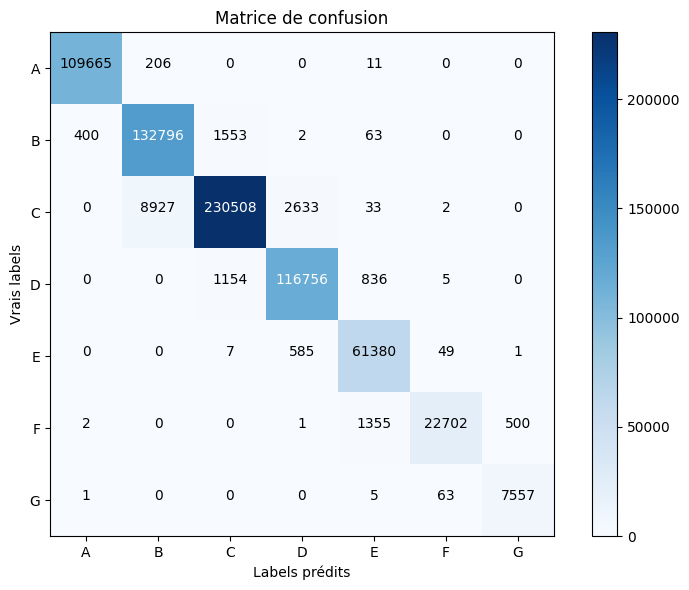

In [44]:
import itertools
def displayConfusionMatrix():
    cnf_matrix = confusion_matrix(y_test, y_pred_test)

    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

    plt.figure(figsize=(8, 6))

    plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar()
    tick_marks = np.arange(len(classes))

        # Ajouter des étiquettes aux axes
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

        # Afficher les valeurs dans chaque case de la matrice
    threshold = cnf_matrix.max() / 2  # Seuil pour la couleur du texte
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cnf_matrix[i, j] > threshold else "black")

    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.tight_layout()
    plt.show()

displayConfusionMatrix()

In [51]:
results = pd.DataFrame(columns=["MODELE"])
new_row = {"MODELE" : "TPOTClassifier",   
                        "A - F1 Score" : class_report['A']['f1-score'],
                        "B - F1 Score" : class_report['B']['f1-score'],
                        "C - F1 Score" : class_report['C']['f1-score'],
                        "D - F1 Score" : class_report['D']['f1-score'],
                        "E - F1 Score" : class_report['E']['f1-score'],
                        "F - F1 Score" : class_report['F']['f1-score'],
                        "G - F1 Score" : class_report['G']['f1-score']}
results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)
print(results)
results.to_csv('tpot_classifications_results.csv', sep=';')


           MODELE  A - F1 Score  B - F1 Score  C - F1 Score  D - F1 Score  \
0  TPOTClassifier      0.997181      0.959706      0.969896      0.978151   

   E - F1 Score  F - F1 Score  G - F1 Score  
0      0.976572      0.958274      0.963657  


In [39]:

# Calculer et afficher le score de précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")



Accuracy score: 0.9737137696174963


In [ ]:
# Exporter le pipeline optimisé en code Python
tpot.export('tpot_classfier_pipeline.py')

In [ ]:
# import pickle

# def savePickleModel(model, filename):
#     with open('../models/' + filename, 'wb') as f:
#         pickle.dump(model, f)
#         f.close()

# savePickleModel(best_model,'TPOTClassifier.pkl')